<center><h1> Algorithme ELO: Tri par comparaison deux à deux </h1></center>

Implémentation de l'algorithme ELO pour faire du tri à l'aide de comparaison deux à deux. Dans le but d'utiliser cette algorithme pour du ranking d'image à l'aide d'un slackbot, nous testons cette algorithme sur un tri simple tel que trier les nombre de 0 à N. 

## Implémentation de l'algorithme

In [481]:
!pip install elo
!pip install progressbar2

In [243]:
from elo import rate_1vs1
import numpy as np
import random
import pandas as pd
import math
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix,precision_score
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from multiprocessing import Pool, cpu_count
from itertools import product,repeat
import progressbar
import pickle

In [23]:
def data(N):
    l = range(0,N)
    score = np.zeros(N)
    return l,score

In [24]:
def matrice_diff(score):
    mat = np.zeros((len(score),len(score)))
    mat = np.tril(mat+np.inf,0)
    return mat

In [25]:
def opponents(score,mat):
    l=np.shape(mat)[1]
    n= np.argmin(mat)
    i=math.floor(n/l)
    j= n % l
    return i,j

In [26]:
def match(opp,score,err,mat):
    A = opp[0]
    B = opp[1]
    error = random.random() < err
    if (A>B and error == False) or (B>A and error == True):
        score[A],score[B] = rate_1vs1(score[A],score[B])
    if (B>A and error == False) or (A>B and error == True):
        score[B],score[A] = rate_1vs1(score[B],score[A])
    T = [abs(x-score[A]) for x in score]
    L = [abs(x-score[A]) for x in score]
    for i in range (A+1):
        T[i] = np.inf
    for j in range (A,len(L)):
        L[j] = np.inf
    mat[A] = T
    mat[:,A] = L
    T = [abs(x-score[B]) for x in score]
    L = [abs(x-score[B]) for x in score]
    for i in range (B+1):
        T[i] = np.inf
    for j in range (B,len(L)):
        L[j] = np.inf
    mat[B] = T
    mat[:,B] = L
    return score , mat

In [27]:
def random_opponents(l):
    opp1,opp2 = np.random.choice(l,2)
    return [opp1,opp2]

## Test de l'algorithme pour N=1000, Random=10 000 et Proche=500

In [131]:
liste,score=data(1000)
mat=matrice_diff(score)

In [28]:
def random_match(n,score,err,mat):
    with progressbar.ProgressBar(max_value=n) as bar:
        for i in range(n):
            opp = random_opponents(liste)
            score,mat=match(opp,score,err,mat)
            bar.update(i)
        return score

In [29]:
def non_random(n,score,err,mat):
    with progressbar.ProgressBar(max_value=n) as bar:
        for i in range(n):
            opp = opponents(score,mat)
            score, mat = match(opp,score,err,mat)
            bar.update(i)
        return score

In [134]:
random_match(10000,score,0,mat)
non_random(1000,score,0,mat)

100% (10000 of 10000) |##################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


array([-9.23772011e+01, -9.19952799e+01, -8.66039380e+01, -6.27704963e+01,
       -9.78960973e+01, -8.21457651e+01, -9.65115163e+01, -9.90461577e+01,
       -8.00570002e+01, -7.77635182e+01, -8.23759294e+01, -8.78514196e+01,
       -7.65709898e+01, -9.12366820e+01, -9.49734811e+01, -6.91794635e+01,
       -9.51536419e+01, -9.14796594e+01, -7.52289799e+01, -1.04658484e+02,
       -9.20588949e+01, -7.00058852e+01, -7.36351100e+01, -7.62481354e+01,
       -8.35191397e+01, -9.81383624e+01, -8.74325245e+01, -1.06365471e+02,
       -8.65439045e+01, -6.35585698e+01, -8.14989297e+01, -9.17140380e+01,
       -8.14438073e+01, -1.19727992e+02, -7.74753992e+01, -1.09205345e+02,
       -8.70218146e+01, -8.26884604e+01, -6.97926593e+01, -1.11013570e+02,
       -9.39596002e+01, -9.62741514e+01, -8.68814139e+01, -8.20257824e+01,
       -8.90942400e+01, -8.56805704e+01, -9.54034750e+01, -6.41959864e+01,
       -9.80175668e+01, -7.78684712e+01, -5.78123203e+01, -5.85263975e+01,
       -6.85591778e+01, -

In [135]:
df = pd.DataFrame(score)

In [30]:
def quantile(x,n):
    return pd.qcut(x,n,duplicates ='drop')

In [31]:
def quality(x,n,score):
    qual = 0
    quant = quantile(score,n)
    for i in range(n):
        if x in quant.categories[i]:
            qual=i+1
    return qual

In [138]:
df['quality']=[quality(x,10,score) for x in df[0]]

### Evaluation

In [139]:
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5,6,7,8,9,10])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.rcParams["figure.figsize"] = (12,12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']

plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [142]:
rmse=math.sqrt(mean_squared_error(y_true, y_pred))
f1=f1_score(y_true,y_pred,average='micro')
accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true, y_pred,average=None,labels=[10])  
print("RMSE pour 1000 photos avec 10000 randoms et 500 non-randoms: ",rmse)
print("F1 pour 1000 photos avec 10000 randoms et 500 non-randoms: ",f1)
print("Accuracy pour 1000 photos avec 10000 randoms et 500 non-randoms: ",accuracy)
print("Precision pour 1000 photos avec 10000 randoms et 500 non-randoms: ",float(precision))

RMSE pour 1000 photos avec 10000 randoms et 500 non-randoms:  0.9022194854911968
F1 pour 1000 photos avec 10000 randoms et 500 non-randoms:  0.508
Accuracy pour 1000 photos avec 10000 randoms et 500 non-randoms:  0.508
Precision pour 1000 photos avec 10000 randoms et 500 non-randoms:  0.6767676767676768


### Evaluation Générale

In [32]:
def matches_eval(nb_random=10000,nb_non_random=500,nb_image=1000,n_tile=10,err=0):
    liste,score = data(nb_image)
    mat=matrice_diff(score)
    score=random_match(nb_random,score,err,mat)
    non_random(nb_non_random,score,err,mat)
    y_pred = [quality(x,n_tile,score) for x in score]
    y_true = [quality(x,n_tile,liste) for x in liste]
    precision=precision_score(y_true, y_pred,average=None,labels=[n_tile])  
    return float(precision)

## Impact des erreurs de jugement

#### 0% d'erreur

100% (100000 of 100000) |################| Elapsed Time: 0:04:10 Time:  0:04:10


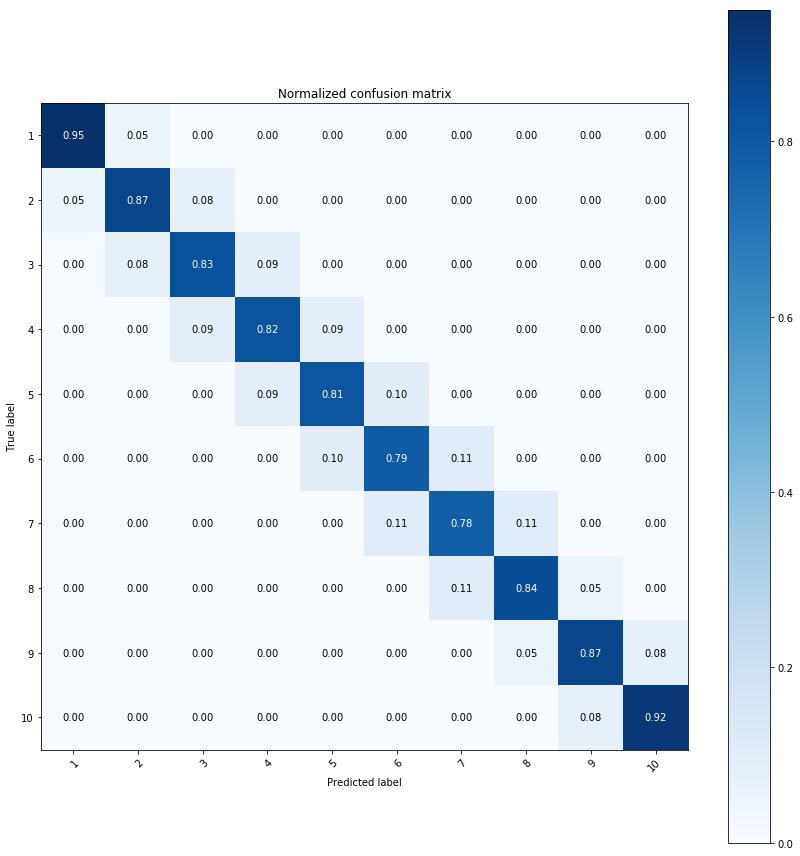

In [145]:
liste,score=data(1000)
mat=matrice_diff(score)
random_match(100000,score,0,mat)
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 10% d'erreur

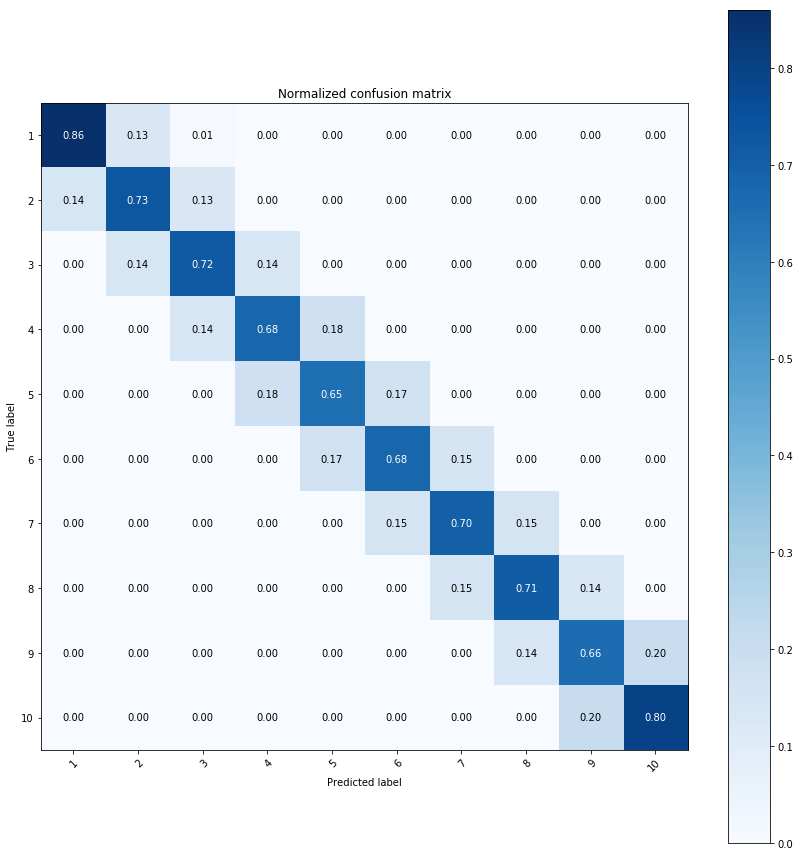

In [80]:
liste,score=data(1000)
mat=matrice_diff(score)
random_match(100000,score,0.1,mat)
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 30% d'erreur

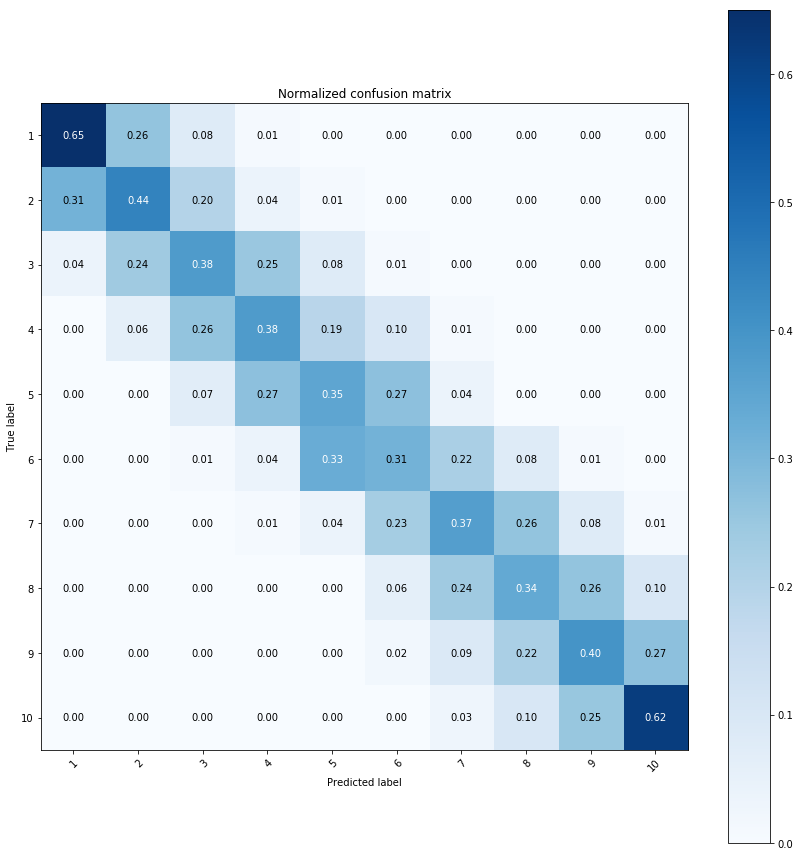

In [81]:
liste,score=data(1000)
mat=matrice_diff(score)
random_match(100000,score,0.3,mat)
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 30% d'erreur temps court

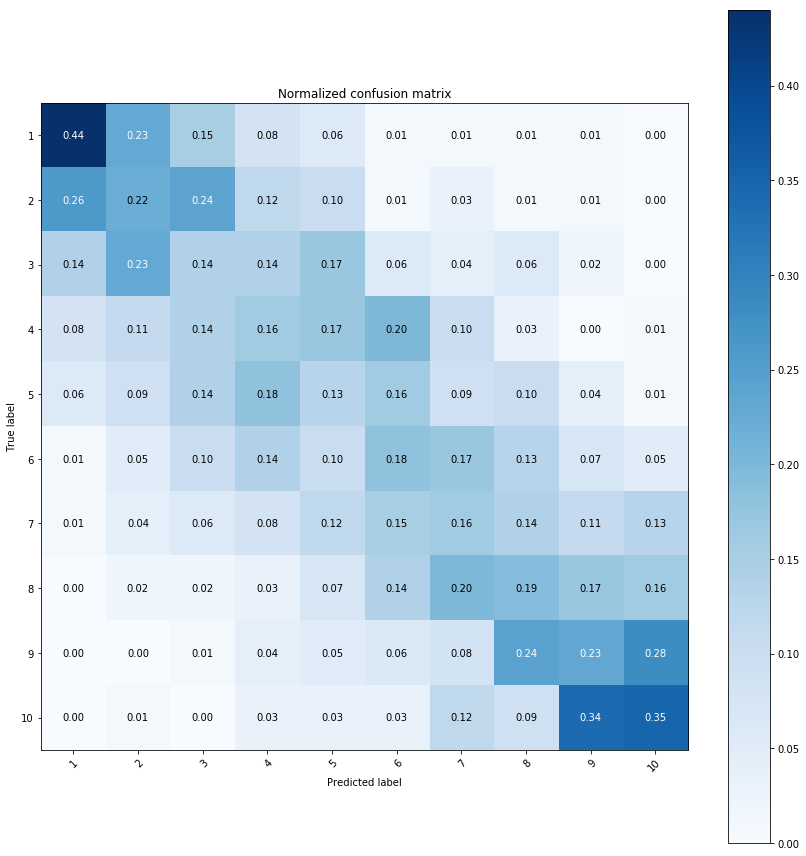

In [82]:
liste,score=data(1000)
mat=matrice_diff(score)
random_match(10000,score,0.3,mat)
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Nombre de votes en fonctions des images

In [341]:
pd.DataFrame({'nb_image': [1000, 2000,3000,4000,5000],
              'nb_ran_50': [3500,7000,10500,14000,17500],
              'nb_ran_50.10': [5000,10000,15000,20000,25000],
              'nb_ran_75': [20000,40000,60000,80000,100000],
              'nb_ran_75.10': [35000,70000,105000,140000,175000],              
             })

,nb_image,nb_ran_50,nb_ran_50.10,nb_ran_75,nb_ran_75.10
0,1000,3500,5000,20000,35000
1,2000,7000,10000,40000,70000
2,3000,10500,15000,60000,105000
3,4000,14000,20000,80000,140000
4,5000,17500,25000,100000,175000


In [361]:
m1000 = pickle.load(open( "./calcul/1000_r35000.p", "rb" ))
m2000 = pickle.load(open( "./calcul/2000_r70000.p", "rb" ))
m3000 = pickle.load(open( "./calcul/3000_r105000.p", "rb" ))
m4000 = pickle.load(open( "./calcul/4000_r140000.p", "rb" ))
m5000 = pickle.load(open( "./calcul/5000_r175000.p", "rb" ))

In [350]:
print('1000: ',m1000)
print('2000: ',m2000)
print('3000: ',m3000)
print('4000: ',m4000)
print('5000: ',m5000)

1000:  0.7437373737373738
2000:  0.7583844221105527
3000:  0.7525039018952062
4000:  0.7488652882205513
5000:  0.7537983967935872


<h3 style='color : darkblue'>Sentiment que le nombre de votes nécessaires dépend linéairement du nombre d'images</h3>

In [309]:
prec = pd.DataFrame({'nb_image': [100, 200,300,400,500,1000,2000],
              'nb_ran_3500': [0.8492592592592592,0.7336842105263159,0.6690421455938698,0.6440170940170942,0.5770748299319728,0.494949494949495,0.385],
              'nb_ran_7000': [0.8951851851851853,0.8216666666666667,0.7664367816091955,0.7246153846153848,0.6967346938775509,0.61,0.485],
              'nb_ran_10500': [0.9292592592592592,0.8652631578947367,0.813639846743295,0.7826923076923079,0.766408163265306,0.68,0.53],
              'nb_ran_14000': [0.9470370370370369,0.8899122807017544,0.8570881226053638,0.8328846153846154,0.7871914098972923,0.7,0.5879396984924623],
              'nb_ran_17500': [0.9574074074074074,0.894298245614035,0.8770114942528734,0.8467307692307693,0.8313605442176871,0.73,0.625],
             })

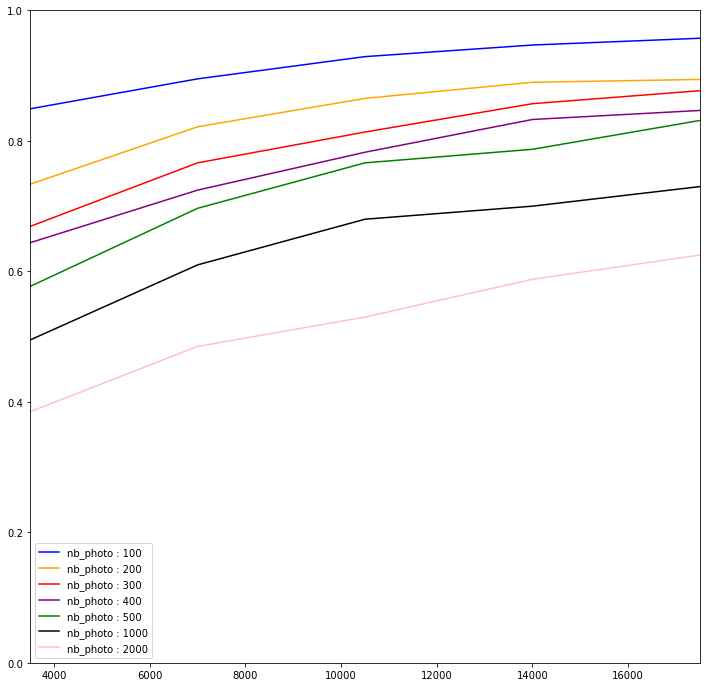

In [310]:
nb_photos = [100,200,300,400,500,1000,2000]
step_random = [3500,7000,10500,14000,17500]
colors=['blue','orange','red','purple','green', 'black','pink','yellow','brown','grey']
plt.plot(step_random, prec.loc[[0]].values[0][1:], colors[0],label='nb_photo : '+str(nb_photos[0])) 
plt.plot(step_random, prec.loc[[1]].values[0][1:], colors[1],label='nb_photo : '+str(nb_photos[1])) 
plt.plot(step_random, prec.loc[[2]].values[0][1:], colors[2],label='nb_photo : '+str(nb_photos[2])) 
plt.plot(step_random, prec.loc[[3]].values[0][1:], colors[3],label='nb_photo : '+str(nb_photos[3])) 
plt.plot(step_random, prec.loc[[4]].values[0][1:], colors[4],label='nb_photo : '+str(nb_photos[4])) 
plt.plot(step_random, prec.loc[[5]].values[0][1:], colors[5],label='nb_photo : '+str(nb_photos[5])) 
plt.plot(step_random, prec.loc[[6]].values[0][1:], colors[6],label='nb_photo : '+str(nb_photos[6])) 
plt.axis([3500,17500, 0, 1])
plt.legend()
plt.show()     

### Random ou non?

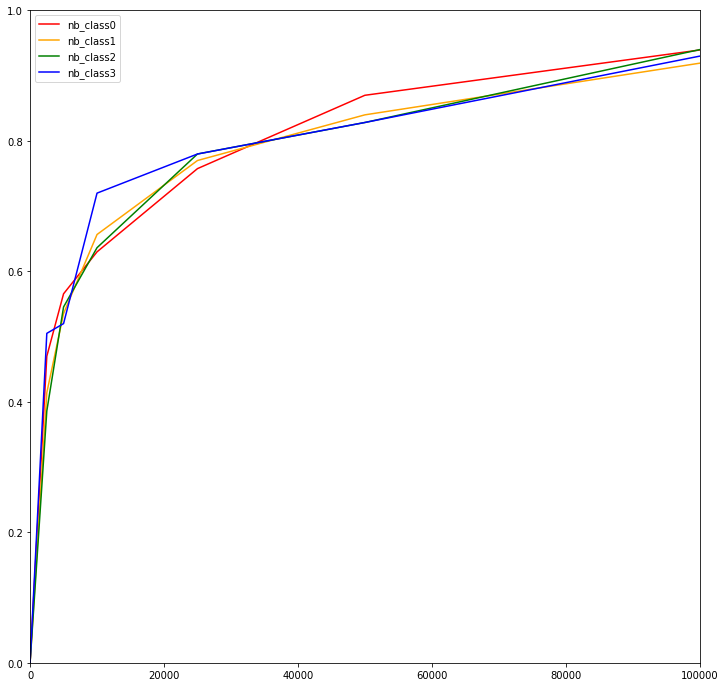

In [76]:
step_random = [2500,5000,10000,25000,50000,100000]
step_clas = [0,100,250,500]
color = ['red','orange','green','blue','purple']
color_nb = 0
for j in range(len(step_clas)):
    step_random = [2500,5000,10000,25000,50000,100000]   
    prec = []
    for i in range(len(step_random)):
        prec.append(matches_eval(step_random[i],step_clas[j],1000,10,0))
    step_random = [0] + step_random
    prec = [0] + prec
    plt.plot(step_random, prec, color[color_nb],label='nb_class' + str(j))                                  
    color_nb = color_nb + 1
    plt.axis([0,100000, 0, 1])
plt.legend()
plt.show()      

In [42]:
pd.DataFrame({'nb_image': [1000, 2000,3000,4000,5000],
              'nb_vote': [20000,40000,60000,80000,100000],
              '0_clas': [0.7455185185185184,0.7510150753768844,0.7534570791527313,0.7502514635508138,0.7485432872398157], 
              '25_clas': [0.7841616161616162,0.8010879396984925,0.7882642140468228,0.784342522974102,0.779991983967936],
              '50_clas': [0.7516296296296295,0.7387211055276384,0.7396785581568189,0.7362999164578112,0.7373676686706747],
              '75_clas': [0.6444848484848485,0.6621256281407035,0.6587714604236343,0.6585904344193818,0.6501315965263861],
             })

,nb_image,nb_vote,0_clas,25_clas,50_clas,75_clas
0,1000,20000,0.745519,0.784162,0.751630,0.644485
1,2000,40000,0.751015,0.801088,0.738721,0.662126
2,3000,60000,0.753457,0.788264,0.739679,0.658771
3,4000,80000,0.750251,0.784343,0.736300,0.658590
4,5000,100000,0.748543,0.779992,0.737368,0.650132


### Variance

In [202]:
liste,score = data(1000)
mat=matrice_diff(score)
v=[]
for i in range (50):
    v.append(matches_eval(5000,0,1000,10,0))

100% (5000 of 5000) |####################| Elapsed Time: 0:00:11 Time:  0:00:11
- |#                                                  | 0 Elapsed Time: 0:00:00
100% (5000 of 5000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12
- |#                                                  | 0 Elapsed Time: 0:00:00
100% (5000 of 5000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12
- |#                                                  | 0 Elapsed Time: 0:00:00
100% (5000 of 5000) |####################| Elapsed Time: 0:00:13 Time:  0:00:13
- |#                                                  | 0 Elapsed Time: 0:00:00
100% (5000 of 5000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12
- |#                                                  | 0 Elapsed Time: 0:00:00
100% (5000 of 5000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12
- |#                                                  | 0 Elapsed Time: 0:00:00
100% (5000 of 5000) |###################

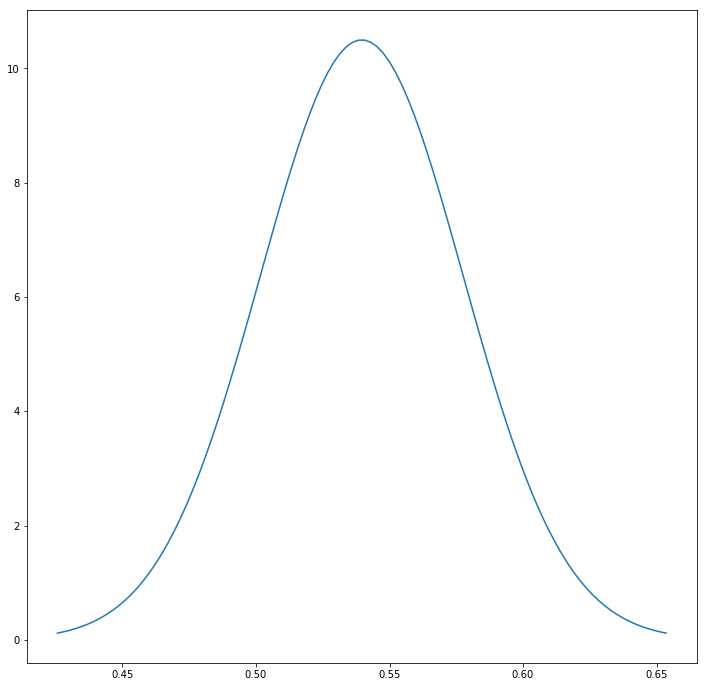

In [392]:
import scipy.stats as stats

mu = np.mean(v)
variance = np.var(v)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

### Best?

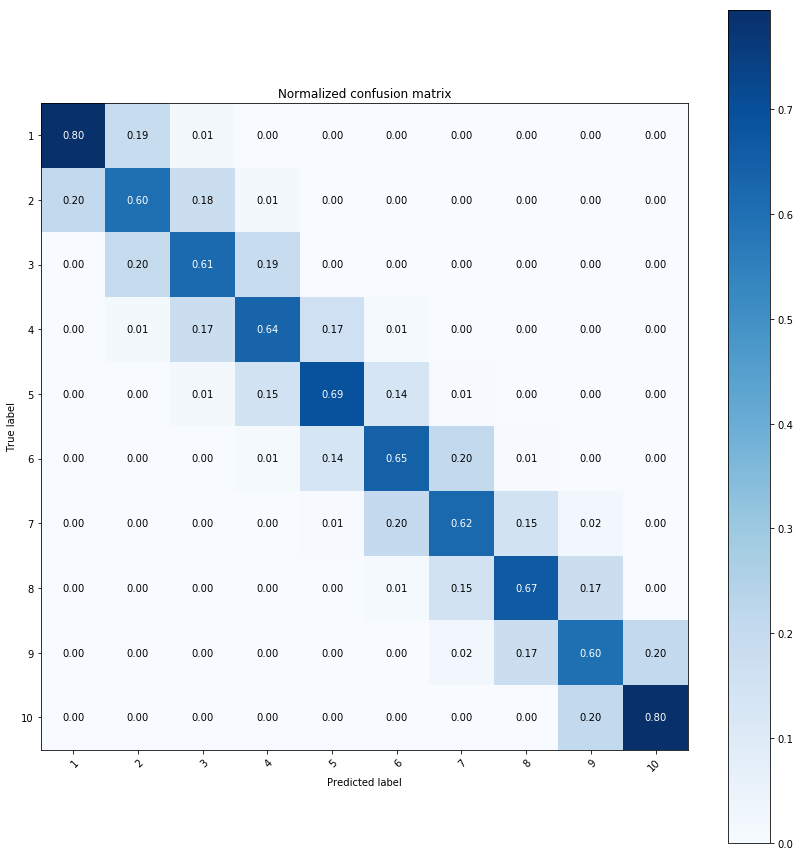

In [18]:
liste,score=data(2000)
mat=matrice_diff(score)
random_match(52500,score,0.1,mat)
non_random(17500,score,0.1,mat)
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

100% (78750 of 78750) |##################| Elapsed Time: 0:08:57 Time:  0:08:57
100% (26250 of 26250) |##################| Elapsed Time: 0:06:37 Time:  0:06:37


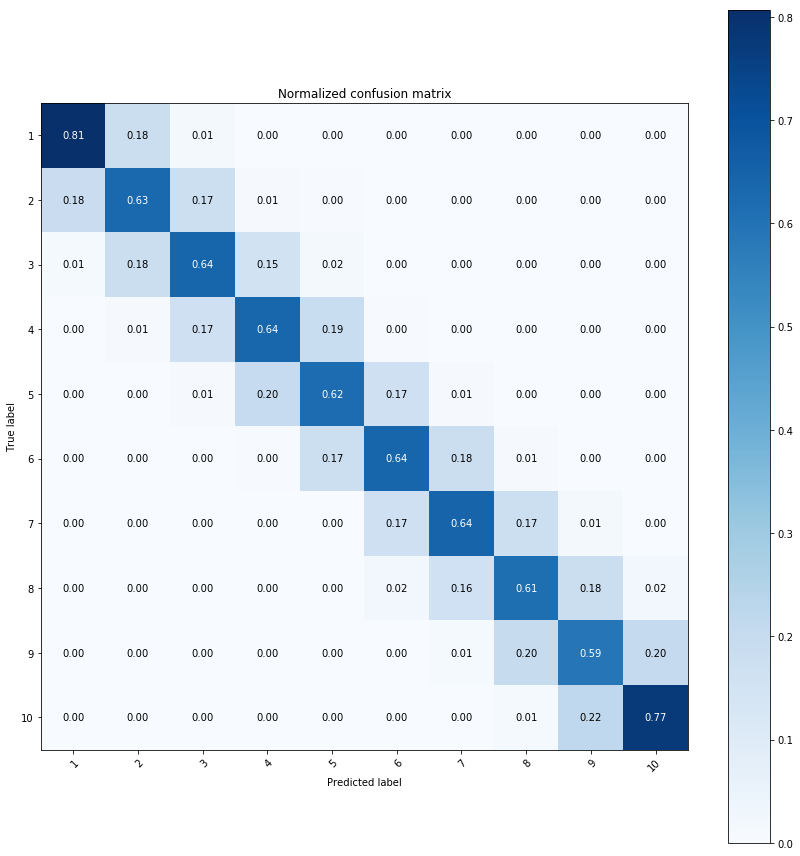

In [21]:
liste,score=data(3000)
mat=matrice_diff(score)
random_match(78750,score,0.1,mat)
non_random(26250,score,0.1,mat)
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Nombre de match necessaire pour une photo enfin d'être bien classée

In [ ]:
liste,score=data(3000)
mat=matrice_diff(score)
random_match(78750,score,0.1,mat)
non_random(26250,score,0.1,mat)
score = np.concatenate((score, [0]))
liste = range(0,3001)

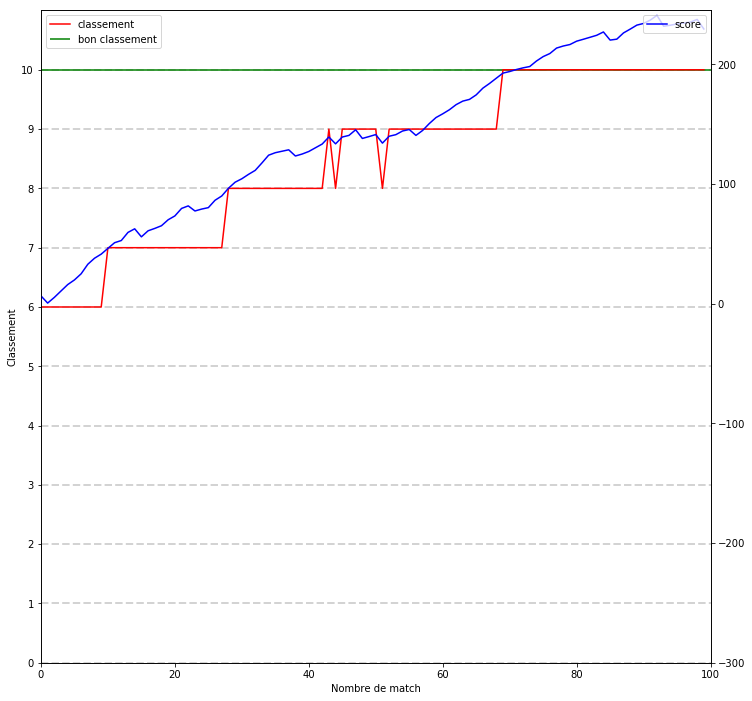

In [247]:
score[3000] = 0
score3000 = [0]
nb_match=[0]
clas=[quality(0,10,score)]
for i in range(100):
    opp = [int(np.random.choice(liste,1)),3000]
    score,mat=match(opp,score,0.1,mat)
    clas.append(quality(score[3000],10,score))
    score3000.append(score[3000])
    nb_match.append(i)
plt.plot(nb_match, clas, 'red',label = 'classement')              
plt.axis([0,100, 0, 11])
plt.xlabel('Nombre de match')
plt.ylabel('Classement')
plt.yticks(range(0,11))
plt.hlines(y=10,xmin=0,xmax=100,color='green',label='bon classement')
plt.grid(color='lightgrey', linestyle='--', linewidth=2,axis='y')
plt.legend(loc='upper left')
plt2 = plt.twinx()
plt2.axis([0,100, -300, 245])
plt2.plot(nb_match, score3000, color='blue',label='score')

plt2.legend(loc='upper right')
plt.show()

## Cas des 1500 selfies

In [248]:
liste,score=data(1500)
mat=matrice_diff(score)
random_match(50000,score,0.1,mat)

100% (50000 of 50000) |##################| Elapsed Time: 0:02:48 Time:  0:02:48


array([-165.04, -184.85, -157.84, ...,  162.04,  164.09,  199.29])

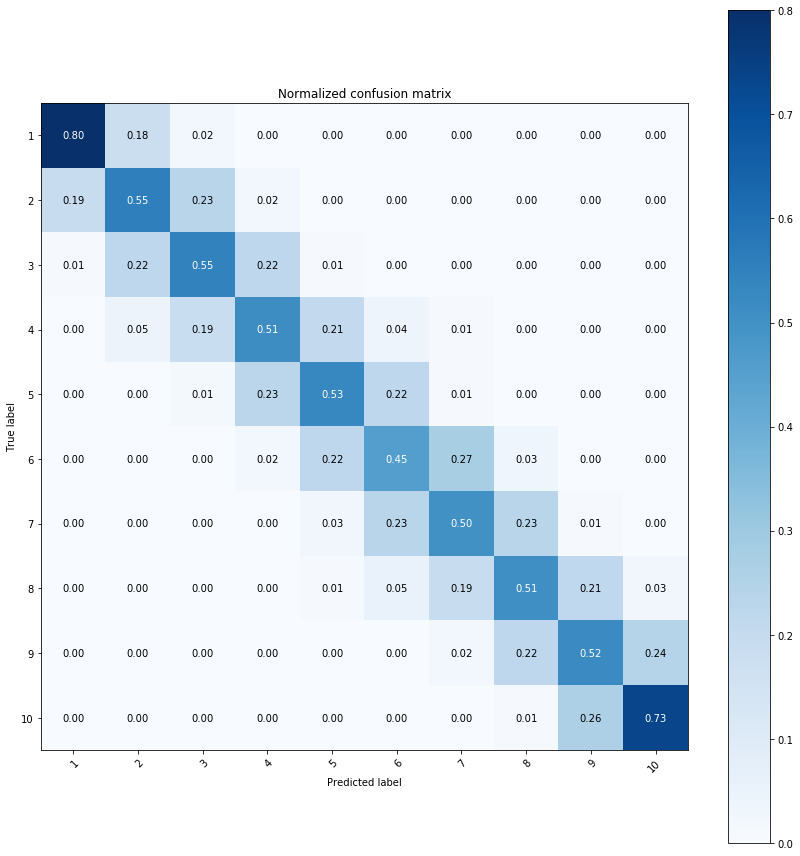

In [249]:
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

# Test

In [259]:
liste = range(0,1500) 
score = np.zeros(1500)+1600
mat=matrice_diff(score)
random_match(50000,score,0.1,mat)

100% (50000 of 50000) |##################| Elapsed Time: 0:02:53 Time:  0:02:53


array([1436.6 , 1423.49, 1411.19, ..., 1746.41, 1750.21, 1750.73])

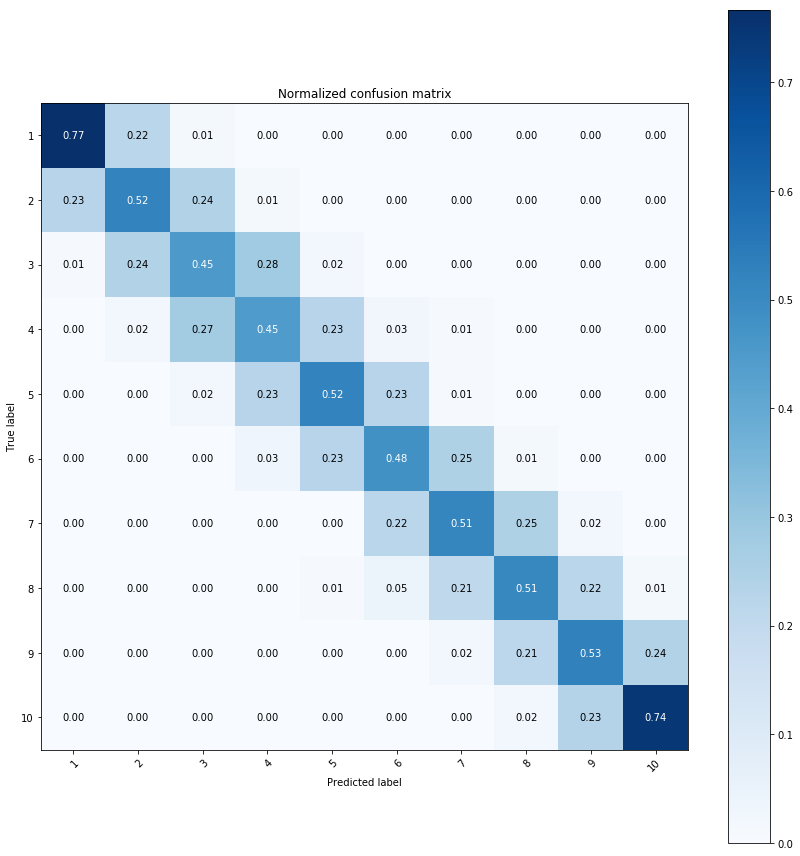

In [260]:
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Definition d'un temps d'arret pour 500 images

In [368]:
liste = range(0,500) 
score = np.zeros(500)+1600
mat=matrice_diff(score)
df = pd.DataFrame(score)
N = 30
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N):
    random_match(1000,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]
var=[]
for i in range(0,N-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (1000 of 1000) |###################

In [406]:
nb_match=range(1000,31000,1000)
f = np.poly1d(np.polyfit(nb_match, [2.512]+var, 10))
f2 =  np.poly1d(np.polyfit(nb_match, prec, 2))

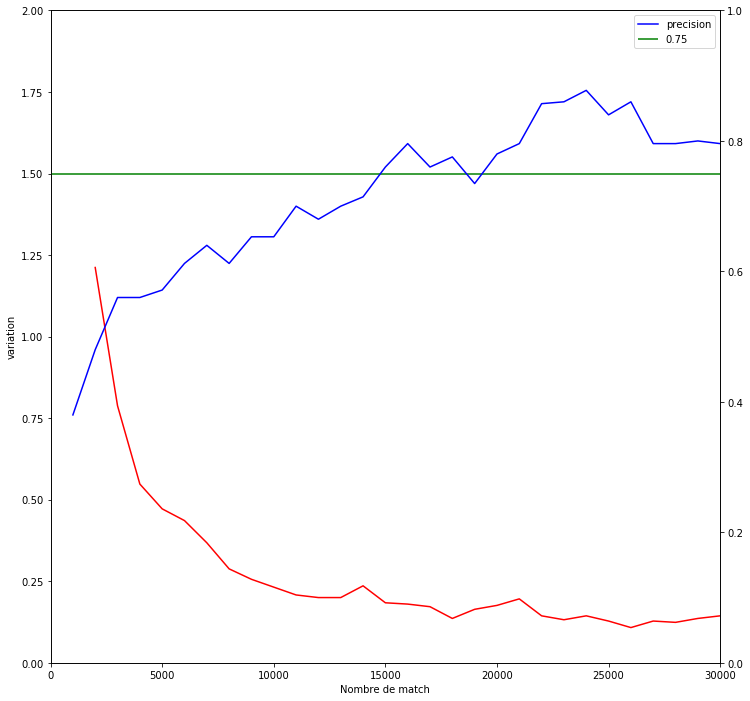

In [444]:
nb_match=range(1000,31000,1000)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,30000, 0, 2])
plt.xlabel('Nombre de match')
plt.ylabel('variation')

plt2 = plt.twinx()
plt2.axis([0,30000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=30000,color='green',label='0.75')

plt2.legend(loc='upper right')
plt.show()

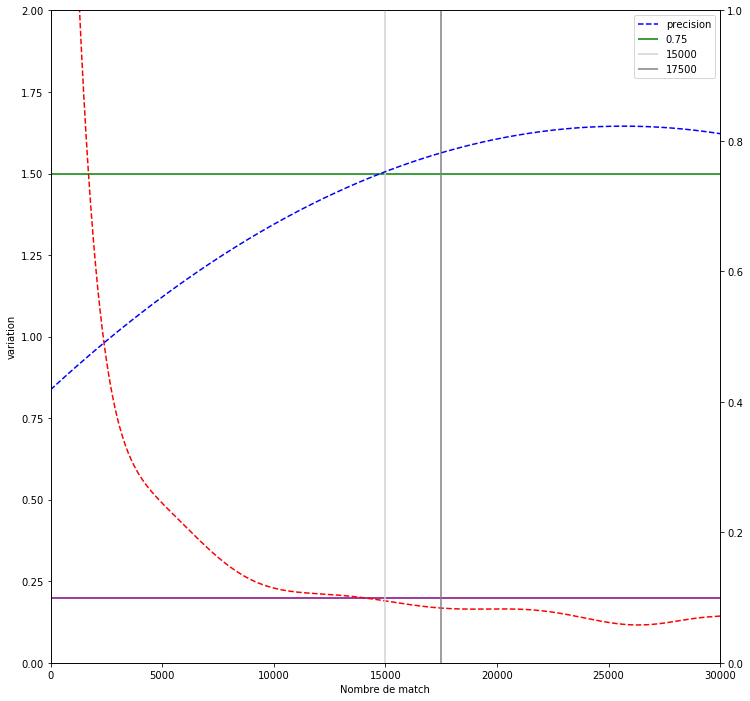

In [442]:


plt.plot(range(0,30001),f(range(0,30001)) ,'--', color='red',label='precision')
plt.axis([0,30000, 0, 2])
plt.hlines(y=0.2,xmin=0,xmax=30000,color='purple',label='0.2')
plt.xlabel('Nombre de match')
plt.ylabel('variation')

plt2 = plt.twinx()
plt2.axis([0,30000, 0, 1])
plt2.plot(range(0,30001),f2(range(0,30001)) ,'--', color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=30000,color='green',label='0.75')
plt2.vlines(x=15000,ymin=0,ymax=1,color='lightgrey',label='15000')
plt2.vlines(x=17500,ymin=0,ymax=1,color='grey',label='17500')
plt2.legend(loc='upper right')

plt.show()

## Definition du temps d'arret pour 1500 images

### 100% random: 1500 images

In [1300]:
liste = range(0,1500) 
score = np.zeros(1500)+1600
mat=matrice_diff(score)
df = pd.DataFrame(score)
N = 70
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]
var=[]
for i in range(0,N-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |###################

In [1301]:
nb_match=range(1500,105001,1500)
f = np.poly1d(np.polyfit(nb_match, [5.404]+var, 10))
f2 =  np.poly1d(np.polyfit(nb_match, prec, 2))

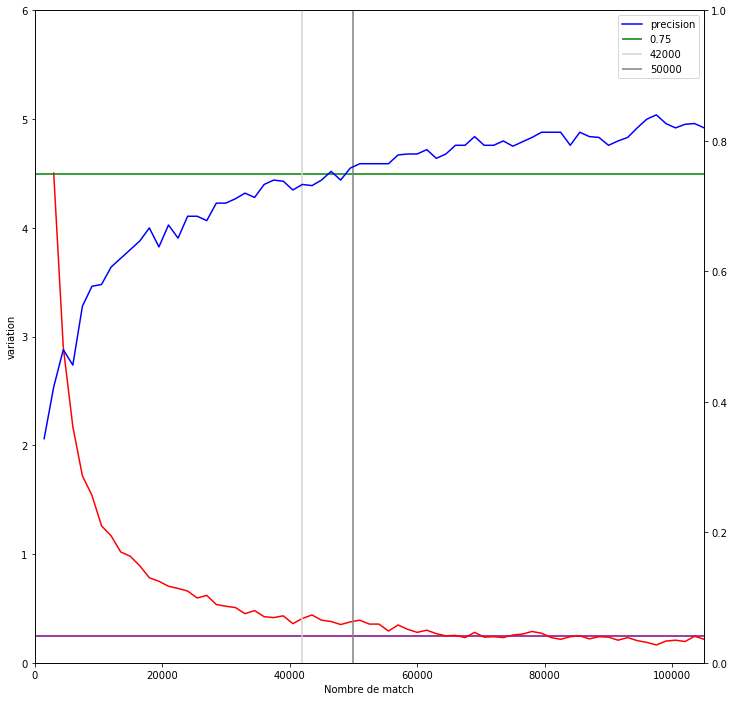

In [1302]:
nb_match=range(1500,105001,1500)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,105000, 0, 6])
plt.xlabel('Nombre de match')
plt.ylabel('variation')
plt.hlines(y=0.25,xmin=0,xmax=105000,color='purple',label='0.25')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=42000,ymin=0,ymax=1,color='lightgrey',label='42000')
plt2.vlines(x=50000,ymin=0,ymax=1,color='grey',label='50000')


plt2.legend(loc='upper right')
plt.show()

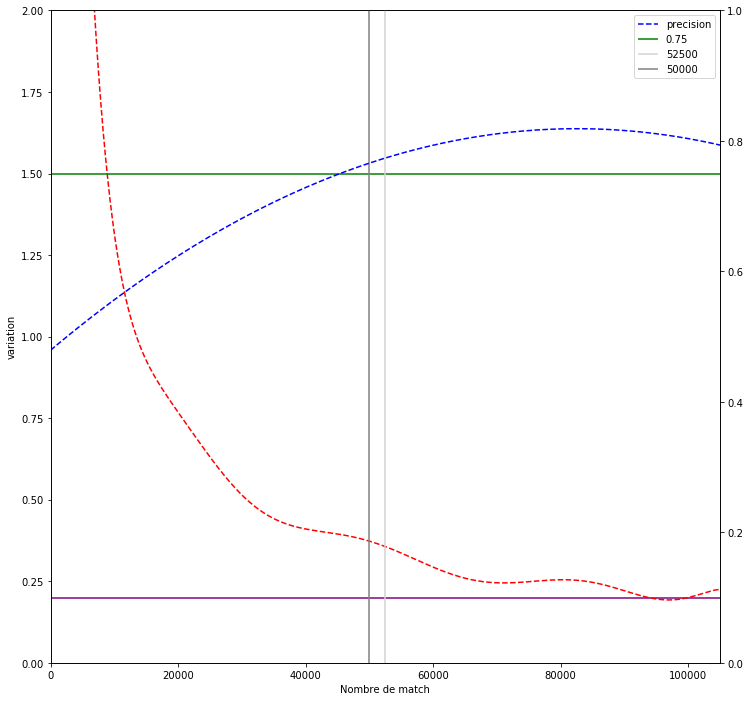

In [1303]:

plt.plot(range(0,105001),f(range(0,105001)) ,'--', color='red',label='precision')
plt.axis([0,105000, 0, 2])
plt.hlines(y=0.2,xmin=0,xmax=105000,color='purple',label='0.2')
plt.xlabel('Nombre de match')
plt.ylabel('variation')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(range(0,105001),f2(range(0,105001)) ,'--', color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=52500,ymin=0,ymax=1,color='lightgrey',label='52500')
plt2.vlines(x=50000,ymin=0,ymax=1,color='grey',label='50000')
plt2.legend(loc='upper right')

plt.show()

### 75% random, 25%nonrandom, random: 1500 images

In [1304]:
liste = range(0,1500) 
score = np.zeros(1500)+1600
mat=matrice_diff(score)
df = pd.DataFrame(score)
N1 = 27
N2 = 35
N3 = 70
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N1):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]
for i in range(N1,N2):
    non_random(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]   
for i in range(N2,N3):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]    
var=[]
for i in range(0,N3-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N3):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |###################

In [1305]:
nb_match=range(1500,105001,1500)
f = np.poly1d(np.polyfit(nb_match, [5.404]+var, 10))
f2 =  np.poly1d(np.polyfit(nb_match, prec, 2))

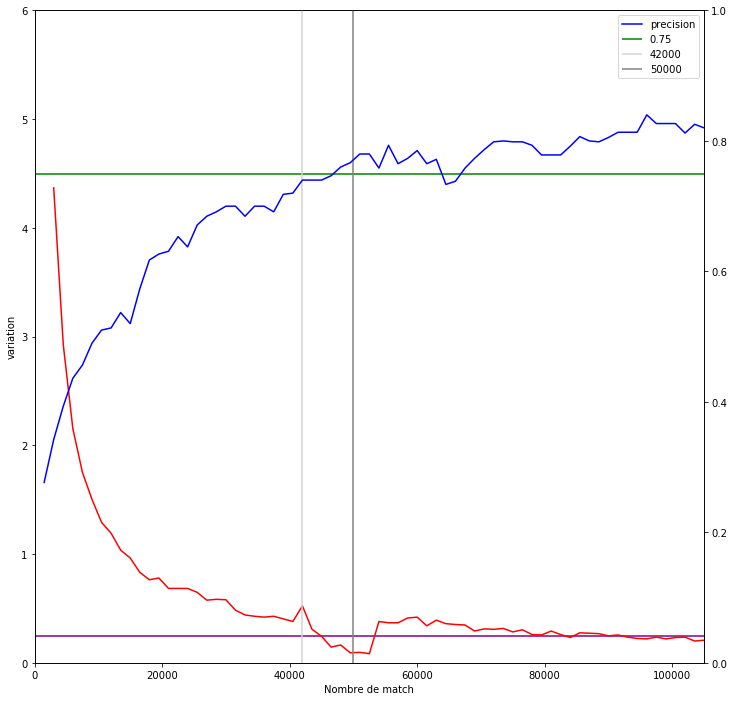

In [1306]:
nb_match=range(1500,105001,1500)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,105000, 0, 6])
plt.xlabel('Nombre de match')
plt.ylabel('variation')
plt.hlines(y=0.25,xmin=0,xmax=105000,color='purple',label='0.25')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=42000,ymin=0,ymax=1,color='lightgrey',label='42000')
plt2.vlines(x=50000,ymin=0,ymax=1,color='grey',label='50000')


plt2.legend(loc='upper right')
plt.show()

### 75% random, 25%nonrandom, non random 1500 images

In [1307]:
liste = range(0,1500) 
score = np.zeros(1500)+1600
mat=matrice_diff(score)
df = pd.DataFrame(score)
N1 = 27
N3 = 70
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N1):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]
for i in range(N1,N3):
    non_random(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]      
var=[]
for i in range(0,N3-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N3):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |###################

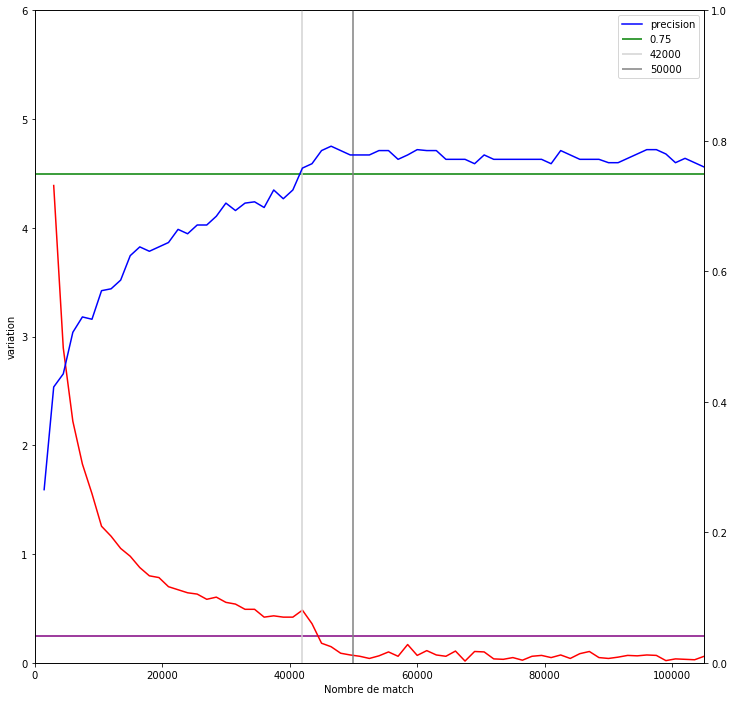

In [498]:
nb_match=range(1500,105001,1500)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,105000, 0, 6])
plt.xlabel('Nombre de match')
plt.ylabel('variation')
plt.hlines(y=0.25,xmin=0,xmax=105000,color='purple',label='0.25')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=42000,ymin=0,ymax=1,color='lightgrey',label='42000')
plt2.vlines(x=50000,ymin=0,ymax=1,color='grey',label='50000')


plt2.legend(loc='upper right')
plt.show()

## Pondéré négativement le random par le nombre de match joué

In [1308]:
def random_opponents_pond(l):
    opp1,opp2 = np.random.choice(l,2,replace = False, p = table_ponderation['weight'])
    return [opp1,opp2]

In [1309]:
def random_match_pond(n,score,err,mat,upd):  
    global df_match
    with progressbar.ProgressBar(max_value=n) as bar:
        for i in range(n):
            opp = random_opponents(liste)
            df_match = df_match.append([opp])
            score,mat=match(opp,score,err,mat)
            if i%upd == 0:
                updateweight()
            bar.update(i)
        return score

In [1310]:
def updateweight():
    table_ponderation['nb_match'] = df_match[0].append(df_match[1]).groupby(0).size()
    table_ponderation['weight'] = [1-x/max(table_ponderation['nb_match']) for x in table_ponderation['nb_match']]
    table_ponderation['weight'] = np.array(table_ponderation['weight'])*np.array(score)/np.linalg.norm(score)
    table_ponderation['weight'] = [x/sum(table_ponderation['weight']) for x in table_ponderation['weight']]

In [1318]:
liste = range(0,100) 
score = np.zeros(100)+1600
mat = matrice_diff(score)
df_match = pd.DataFrame([])
table_ponderation = pd.DataFrame({'nb_match': [0]*100,'weight' : [0.01]*100})
random_match_pond(3500,score,0.1,mat,5)

100% (3500 of 3500) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


array([1396.21, 1410.07, 1447.76, 1394.24, 1412.61, 1413.2 , 1424.64,
       1459.42, 1471.38, 1447.93, 1452.24, 1492.26, 1469.44, 1504.3 ,
       1445.8 , 1472.67, 1464.86, 1489.45, 1468.17, 1472.96, 1452.04,
       1505.38, 1541.29, 1539.62, 1510.63, 1519.86, 1512.71, 1499.95,
       1542.24, 1508.6 , 1516.43, 1499.28, 1526.6 , 1524.67, 1536.84,
       1522.02, 1516.73, 1547.63, 1544.06, 1576.64, 1560.07, 1574.17,
       1606.89, 1616.83, 1554.16, 1606.14, 1529.68, 1559.6 , 1552.11,
       1626.12, 1583.91, 1598.79, 1655.37, 1621.34, 1589.38, 1660.48,
       1637.37, 1635.36, 1647.62, 1552.24, 1633.01, 1635.36, 1686.23,
       1637.39, 1649.8 , 1680.1 , 1696.81, 1663.72, 1647.17, 1637.77,
       1686.1 , 1719.41, 1718.37, 1680.57, 1701.23, 1680.85, 1681.23,
       1698.47, 1758.1 , 1709.27, 1683.99, 1718.11, 1735.29, 1718.98,
       1715.4 , 1737.9 , 1731.42, 1753.63, 1736.83, 1737.63, 1773.44,
       1773.76, 1767.49, 1765.51, 1787.74, 1733.29, 1766.98, 1774.98,
       1763.39, 1802

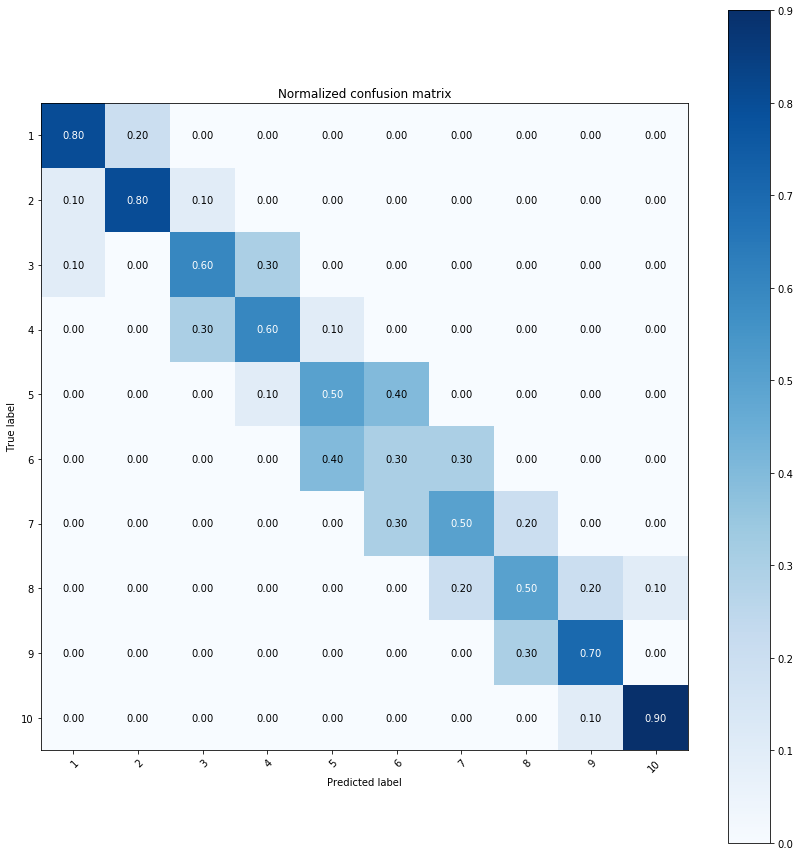

In [1319]:
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [1047]:
liste = range(0,100) 
score = np.zeros(100)+1600
mat = matrice_diff(score)
df_match = pd.DataFrame([])
table_ponderation = pd.DataFrame({'nb_match': [0]*100,'weight' : [0.01]*100})
random_match(1626,score,0.1,mat)
random_match_pond(812,score,0.1,mat,5)
non_random(812,score,0.1,mat)

100% (1626 of 1626) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (812 of 812) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (812 of 812) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


array([1435.34, 1468.98, 1464.42, 1472.25, 1459.01, 1444.67, 1450.27,
       1478.03, 1466.  , 1488.45, 1481.62, 1470.57, 1479.92, 1485.86,
       1492.81, 1490.12, 1494.13, 1498.82, 1506.15, 1499.61, 1515.88,
       1509.68, 1514.99, 1517.5 , 1519.72, 1537.14, 1524.23, 1528.94,
       1534.32, 1557.13, 1539.29, 1544.21, 1526.92, 1553.98, 1548.99,
       1541.41, 1563.94, 1545.84, 1559.04, 1569.19, 1561.6 , 1574.44,
       1578.78, 1583.48, 1576.19, 1593.56, 1598.1 , 1604.02, 1606.67,
       1608.7 , 1614.02, 1623.78, 1602.22, 1585.57, 1627.95, 1617.98,
       1620.01, 1622.29, 1632.28, 1637.78, 1635.13, 1625.63, 1641.67,
       1646.89, 1650.89, 1652.41, 1630.16, 1654.53, 1656.35, 1661.04,
       1665.46, 1670.54, 1678.38, 1672.24, 1680.7 , 1683.14, 1662.8 ,
       1689.34, 1691.33, 1693.37, 1703.4 , 1711.08, 1686.84, 1705.98,
       1700.33, 1743.56, 1707.58, 1713.42, 1718.62, 1715.31, 1723.65,
       1668.29, 1729.55, 1735.41, 1739.62, 1725.89, 1733.46, 1747.88,
       1741.5 , 1757

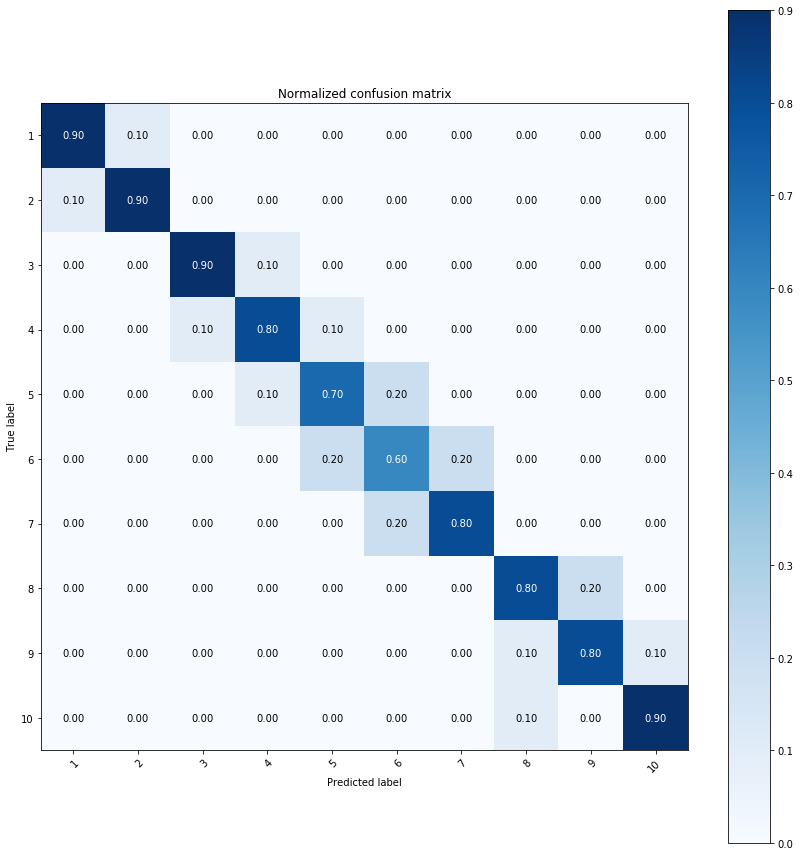

In [1048]:
df = pd.DataFrame(score)
df['quality']=[quality(x,10,score) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### 50%randon, 25%pond,25%nonrandom, random: 1500 images

In [1356]:
liste = range(0,1500) 
score = np.zeros(1500)+1600
mat=matrice_diff(score)
df_match = pd.DataFrame([])
table_ponderation = pd.DataFrame({'nb_match': [0]*1500,'weight' : [1/1500]*1500})
df = pd.DataFrame(score)
N1 = 18
N2 = 27
N3 = 35
N4 = 70
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N1):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]
for i in range(N1,N2):
    random_match_pond(1500,score,0.1,mat,15)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]
for i in range(N2,N3):
    non_random(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]   
for i in range(N3,N4):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]    
var=[]
for i in range(0,N4-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N4):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |###################

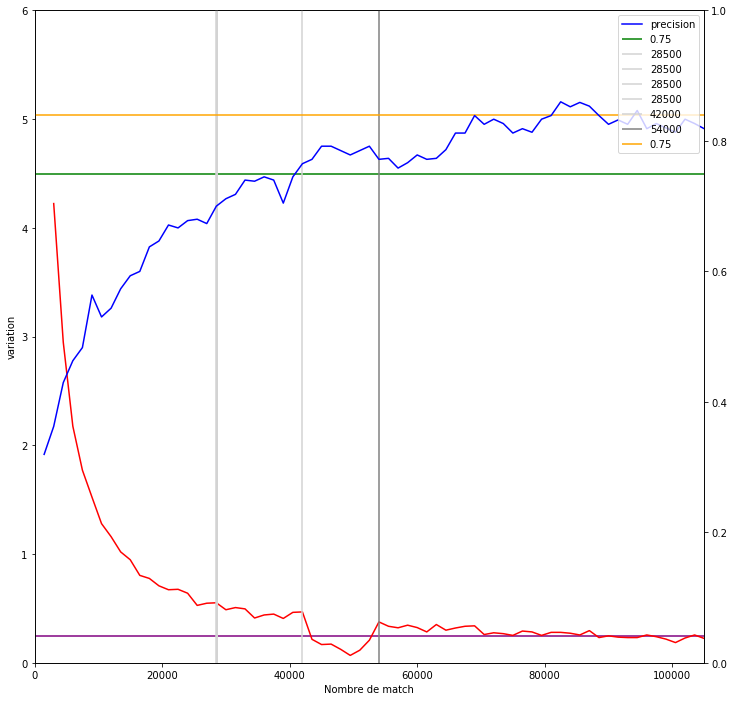

In [1357]:
nb_match=range(1500,105001,1500)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,105000, 0, 6])
plt.xlabel('Nombre de match')
plt.ylabel('variation')
plt.hlines(y=0.25,xmin=0,xmax=105000,color='purple',label='0.25')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=28500,ymin=0,ymax=1,color='lightgrey',label='28500')
plt2.vlines(x=28550,ymin=0,ymax=1,color='lightgrey',label='28500')
plt2.vlines(x=28600,ymin=0,ymax=1,color='lightgrey',label='28500')
plt2.vlines(x=28650,ymin=0,ymax=1,color='lightgrey',label='28500')
plt2.vlines(x=42000,ymin=0,ymax=1,color='lightgrey',label='42000')
plt2.vlines(x=54000,ymin=0,ymax=1,color='grey',label='54000')
plt2.hlines(y=0.84,xmin=0,xmax=105000,color='orange',label='0.75')

plt2.legend(loc='upper right')
plt.show()

<h3 style='color : red'>A tester 25% non random apres 50% random </h3>

### 100%random, non random : 1500 images

In [1092]:
liste = range(0,1500) 
score = np.zeros(1500)+1600
mat=matrice_diff(score)
df_match = pd.DataFrame([])
table_ponderation = pd.DataFrame({'nb_match': [0]*1500,'weight' : [1/1500]*1500})
df = pd.DataFrame(score)
N1 = 18
N2 = 27
N3 = 35
N4 = 70
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N3):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]
for i in range(N3,N4):
    non_random(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]    
var=[]
for i in range(0,N4-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N4):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |###################

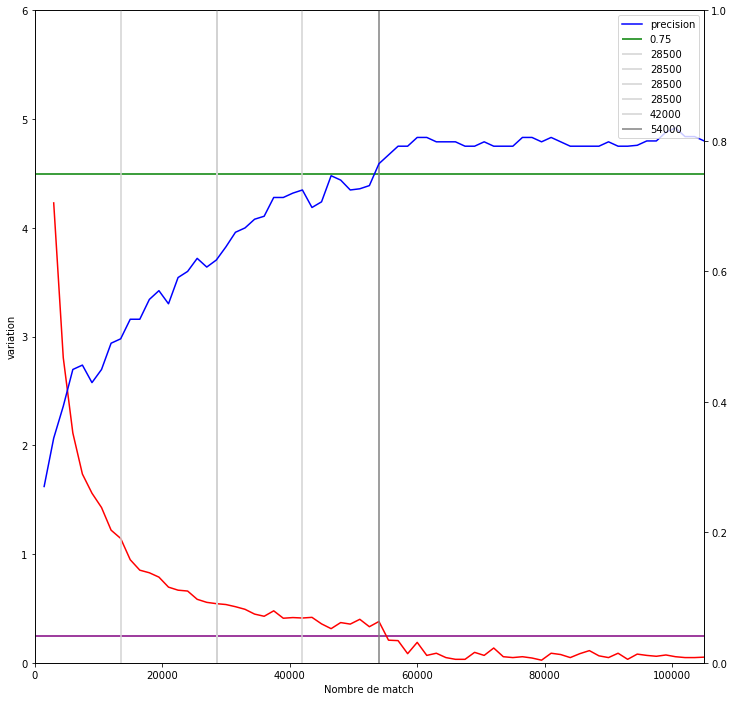

In [1094]:
nb_match=range(1500,105001,1500)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,105000, 0, 6])
plt.xlabel('Nombre de match')
plt.ylabel('variation')
plt.hlines(y=0.25,xmin=0,xmax=105000,color='purple',label='0.25')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=9*1500,ymin=0,ymax=1,color='lightgrey',label='28500')
plt2.vlines(x=28550,ymin=0,ymax=1,color='lightgrey',label='28500')
plt2.vlines(x=28600,ymin=0,ymax=1,color='lightgrey',label='28500')
plt2.vlines(x=28650,ymin=0,ymax=1,color='lightgrey',label='28500')
plt2.vlines(x=42000,ymin=0,ymax=1,color='lightgrey',label='42000')
plt2.vlines(x=54000,ymin=0,ymax=1,color='grey',label='54000')


plt2.legend(loc='upper right')
plt.show()

#### En effectuant du random pondéré on converge plus rapidement vers les 75%.  Faire du non_random juste avant les 75% permet de faire un petit saut pour les atteindre plus rapidement et de s'assurer que nombre necessaire de vote on soit au dessus des 75%. Continuer après ca avec du random pondéré, ne donne pas de super résultats car ayant fait du non random le random pondéré va chercher a affronter les images qui non pas été voté lors du non random, or ces images sont celle avec des scores les plus éloignés des autres photos autour d'elle et donc celle qui semble etre deja bien placer. On va donc preféré faire du random jusqu'a ce que la précision stagne. 

### Test Glicko

In [1169]:
!pip install -e git+https://github.com/sublee/glicko#egg={ 'glicko' }


Obtaining glicko from git+https://github.com/sublee/glicko#egg=glicko
  git clone in ./src/glicko exists with URL git://github.com/sublee/glicko.git
  The plan is to install the git repository https://github.com/sublee/glicko
What to do?  (s)witch, (i)gnore, (w)ipe, (b)ackup ^C
Operation cancelled by user


In [1175]:
import glicko

In [1210]:
Glicko=glicko.Glicko()

In [1231]:
rPlayerA = Glicko.create_rating()
rPlayerB = Glicko.create_rating()
rPlayerB.mu = 1500
rPlayerC = Glicko.create_rating()
rPlayerC.mu = 1600
rPlayerD = Glicko.create_rating()
rPlayerD.mu = 1200

In [1233]:
series = [(1,rPlayerB),(0,rPlayerC),(1,rPlayerD)]

In [1238]:
rPlayerA = Glicko.rate(rating=rPlayerA,series=series)

In [1239]:
rPlayerA

glicko.Rating(mu=1571.014, sigma=234.741, rated_at=1555507524.0)

## Def match glicko

In [1251]:
def match_glicko(opp,score,err,mat):
    A = opp[0]
    B = opp[1]
    error = random.random() < err
    if (A>B and error == False) or (B>A and error == True):
        score[A] = Glicko.rate(rating=score[A],series=[(1,score[B])])
        score[B] = Glicko.rate(rating=score[B],series=[(0,score[A])])
    if (B>A and error == False) or (A>B and error == True):
        score[A] = Glicko.rate(rating=score[A],series=[(0,score[B])])
        score[B] = Glicko.rate(rating=score[B],series=[(1,score[A])])
    T = [abs(x.mu-score[A].mu) for x in score]
    L = [abs(x.mu-score[A].mu) for x in score]
    for i in range (A+1):
        T[i] = np.inf
    for j in range (A,len(L)):
        L[j] = np.inf
    mat[A] = T
    mat[:,A] = L
    T = [abs(x.mu-score[B].mu) for x in score]
    L = [abs(x.mu-score[B].mu) for x in score]
    for i in range (B+1):
        T[i] = np.inf
    for j in range (B,len(L)):
        L[j] = np.inf
    mat[B] = T
    mat[:,B] = L
    return score , mat

In [1246]:
def random_match_glicko(n,score,err,mat):
    with progressbar.ProgressBar(max_value=n) as bar:
        for i in range(n):
            opp = random_opponents(liste)
            score,mat=match_glicko(opp,score,err,mat)
            bar.update(i)
        return score

In [1260]:
N = 1500
liste = range(0,N)
score = score = [Glicko.create_rating()]*N
mat=matrice_diff(score)
random_match_glicko(30000,score,0.1,mat)

100% (30000 of 30000) |##################| Elapsed Time: 0:01:00 Time:  0:01:00


[glicko.Rating(mu=894.660, sigma=83.372, rated_at=1555508827.0),
 glicko.Rating(mu=1060.509, sigma=98.753, rated_at=1555508826.0),
 glicko.Rating(mu=941.162, sigma=91.352, rated_at=1555508827.0),
 glicko.Rating(mu=988.856, sigma=124.036, rated_at=1555508825.0),
 glicko.Rating(mu=1027.698, sigma=102.921, rated_at=1555508826.0),
 glicko.Rating(mu=1040.982, sigma=88.456, rated_at=1555508825.0),
 glicko.Rating(mu=1206.359, sigma=83.062, rated_at=1555508827.0),
 glicko.Rating(mu=999.187, sigma=81.036, rated_at=1555508827.0),
 glicko.Rating(mu=1033.811, sigma=97.001, rated_at=1555508826.0),
 glicko.Rating(mu=841.125, sigma=98.977, rated_at=1555508827.0),
 glicko.Rating(mu=1067.321, sigma=81.198, rated_at=1555508827.0),
 glicko.Rating(mu=1148.722, sigma=84.035, rated_at=1555508821.0),
 glicko.Rating(mu=990.517, sigma=100.690, rated_at=1555508826.0),
 glicko.Rating(mu=1166.610, sigma=73.288, rated_at=1555508823.0),
 glicko.Rating(mu=1191.731, sigma=74.950, rated_at=1555508826.0),
 glicko.Ratin

In [1261]:
score_mu= [x.mu for x in score]

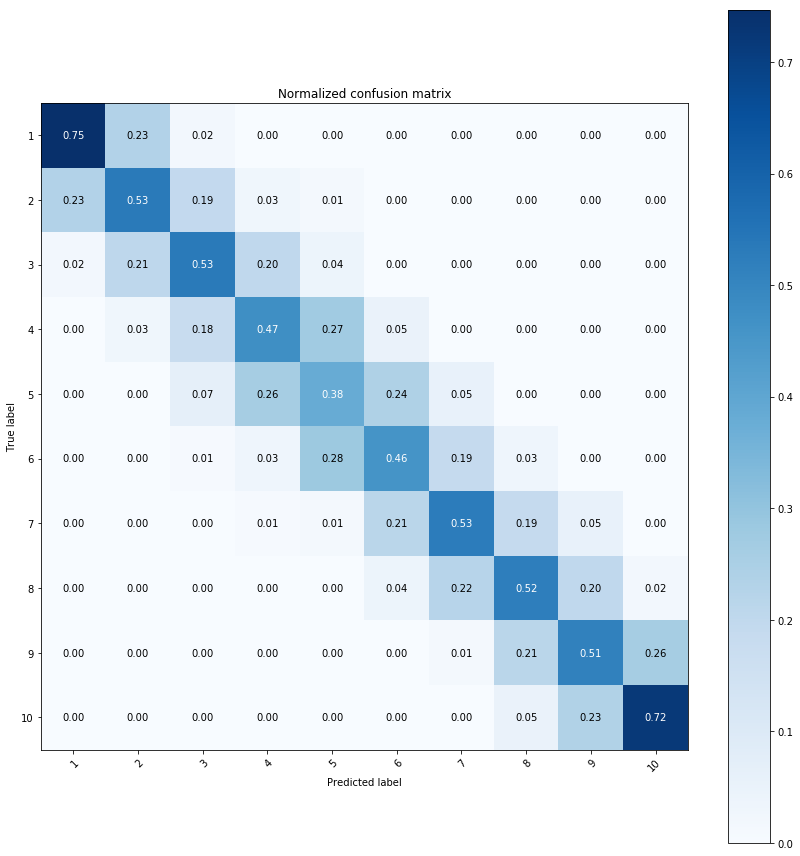

In [1262]:
df = pd.DataFrame(score_mu)
df['quality']=[quality(x,10,score_mu) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [1341]:
def updateweight_pond():
    global table_ponderation
    score_sigma = [x.sigma for x in score]
    table_ponderation['weight'] = np.array(table_ponderation['weight'])*np.array(score_sigma)/np.linalg.norm(score_sigma)
    table_ponderation['weight'] = [x/sum(table_ponderation['weight']) for x in table_ponderation['weight']]

In [1334]:
def random_match_glicko_pond(n,score,err,mat,upd):  
    global df_match
    with progressbar.ProgressBar(max_value=n) as bar:
        for i in range(n):
            opp = random_opponents(liste)
            score,mat=match_glicko(opp,score,err,mat)
            if i%upd == 0:
                updateweight_pond()
            bar.update(i)
        return score

In [1271]:
def random_opponents_pond(l):
    opp1,opp2 = np.random.choice(l,2,replace = False, p = table_ponderation['weight'])
    return [opp1,opp2]

In [1364]:
N = 1500
liste = range(0,N)
score = score = [Glicko.create_rating()]*N
mat=matrice_diff(score)
random_match_glicko(52500,score,0.1,mat)
table_ponderation = pd.DataFrame({'weight' : [0.01]*N})

100% (52500 of 52500) |##################| Elapsed Time: 0:01:44 Time:  0:01:44


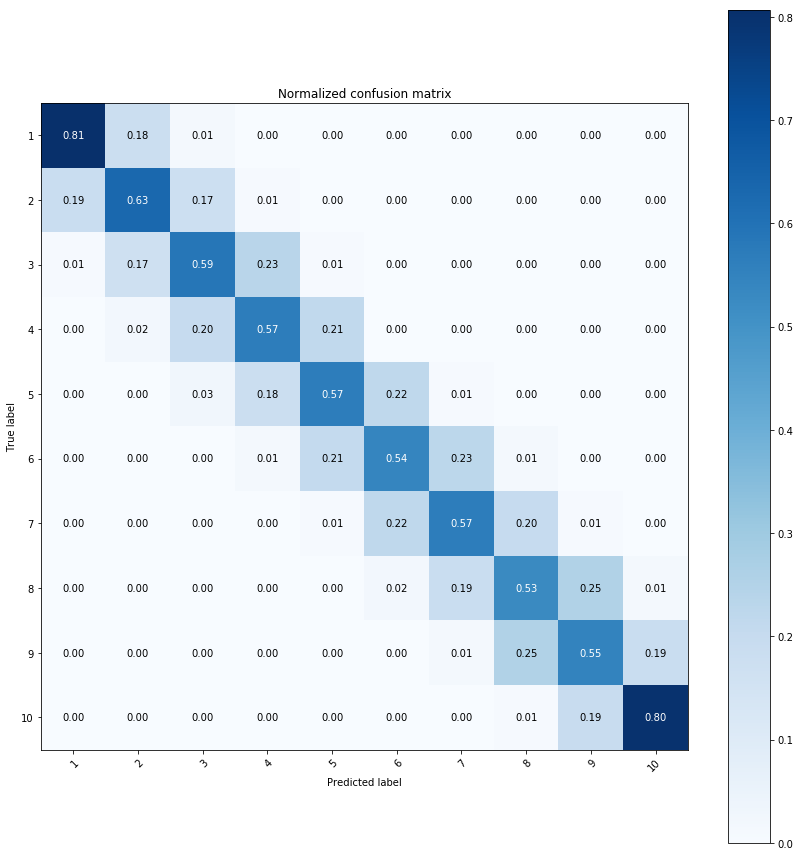

In [1365]:
score_mu= [x.mu for x in score]
df = pd.DataFrame(score_mu)
df['quality']=[quality(x,10,score_mu) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [1281]:
def non_random_glicko(n,score,err,mat):
    with progressbar.ProgressBar(max_value=n) as bar:
        for i in range(n):
            opp = opponents(score,mat)
            score, mat = match_glicko(opp,score,err,mat)
            bar.update(i)
        return score

## Glicko: random75, nonrandom25, random

In [1296]:
N = 1500
liste = range(0,N)
score = score = [Glicko.create_rating()]*N
mat=matrice_diff(score)
score_mu= [x.mu for x in score]
df = pd.DataFrame([])
N1 = 27
N2 = 35
N3 = 70
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N1):
    random_match_glicko(1500,score,0.1,mat)
    score_mu= [x.mu for x in score]
    df['pred'+str(i+1)]=[quality(x,10,score_mu) for x in score_mu]
for i in range(N1,N2):
    non_random_glicko(1500,score,0.1,mat)
    score_mu= [x.mu for x in score]
    df['pred'+str(i+1)]=[quality(x,10,score_mu) for x in score_mu]   
for i in range(N2,N3):
    random_match_glicko(1500,score,0.1,mat)
    score_mu= [x.mu for x in score]
    df['pred'+str(i+1)]=[quality(x,10,score_mu) for x in score_mu]    
var=[]
for i in range(0,N3-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N3):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1500 of 1500) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |###################

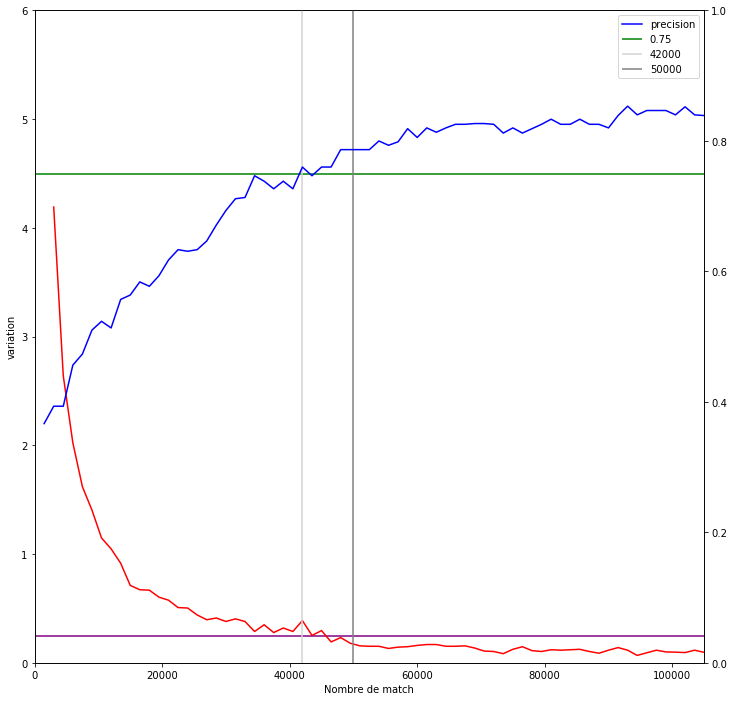

In [1297]:
nb_match=range(1500,105001,1500)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,105000, 0, 6])
plt.xlabel('Nombre de match')
plt.ylabel('variation')
plt.hlines(y=0.25,xmin=0,xmax=105000,color='purple',label='0.25')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=42000,ymin=0,ymax=1,color='lightgrey',label='42000')
plt2.vlines(x=50000,ymin=0,ymax=1,color='grey',label='50000')


plt2.legend(loc='upper right')
plt.show()

In [1344]:
N = 1500
liste = range(0,N)
score  = [Glicko.create_rating()]*N
mat=matrice_diff(score)
score_mu= [x.mu for x in score]
table_ponderation = pd.DataFrame({'weight' : [0.01]*N})
df = pd.DataFrame([])
N1 = 18
N2 = 27
N3 = 35
N4 = 70
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N1):
    random_match_glicko(1500,score,0.1,mat)
    score_mu= [x.mu for x in score]
    df['pred'+str(i+1)]=[quality(x,10,score_mu) for x in score_mu]
for i in range(N1,N2):
    random_match_glicko_pond(1500,score,0.1,mat,15)
    score_mu= [x.mu for x in score]
    df['pred'+str(i+1)]=[quality(x,10,score_mu) for x in score_mu]
for i in range(N2,N3):
    non_random_glicko(1500,score,0.1,mat)
    score_mu= [x.mu for x in score]
    df['pred'+str(i+1)]=[quality(x,10,score_mu) for x in score_mu]   
for i in range(N3,N4):
    random_match_glicko(1500,score,0.1,mat)
    score_mu= [x.mu for x in score]
    df['pred'+str(i+1)]=[quality(x,10,score_mu) for x in score_mu]    
var=[]
for i in range(0,N4-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N4):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1500 of 1500) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1500 of 1500) |###################

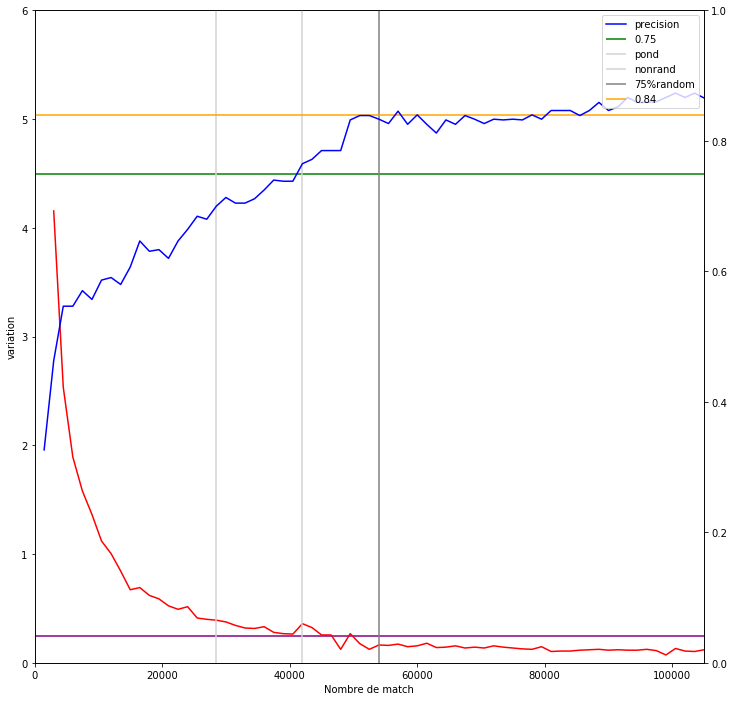

In [1353]:
nb_match=range(1500,105001,1500)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,105000, 0, 6])
plt.xlabel('Nombre de match')
plt.ylabel('variation')
plt.hlines(y=0.25,xmin=0,xmax=105000,color='purple',label='0.25')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=28500,ymin=0,ymax=1,color='lightgrey',label='pond')
plt2.vlines(x=42000,ymin=0,ymax=1,color='lightgrey',label='nonrand')
plt2.vlines(x=54000,ymin=0,ymax=1,color='grey',label='75%random')
plt2.hlines(y=0.84,xmin=0,xmax=105000,color='orange',label='0.84')

plt2.legend(loc='upper right')
plt.show()

## Elo: random75, nonrandom25, random

In [1298]:
liste = range(0,1500) 
score = np.zeros(1500)+1600
mat=matrice_diff(score)
df = pd.DataFrame(score)
N1 = 27
N2 = 35
N3 = 70
df['true']=[quality(x,10,liste) for x in liste]
for i in range(0,N1):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]
for i in range(N1,N2):
    non_random(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]   
for i in range(N2,N3):
    random_match(1500,score,0.1,mat)
    df['pred'+str(i+1)]=[quality(x,10,score) for x in score]    
var=[]
for i in range(0,N3-1):
    var.append(sum(abs(df['pred'+str(i+1)]-df['pred'+str(i+2)]))/500)
prec=[]
for i in range(0,N3):
    prec.append(float(precision_score(df['true'], df['pred'+str(i+1)],average=None,labels=[10])))

100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (1500 of 1500) |###################

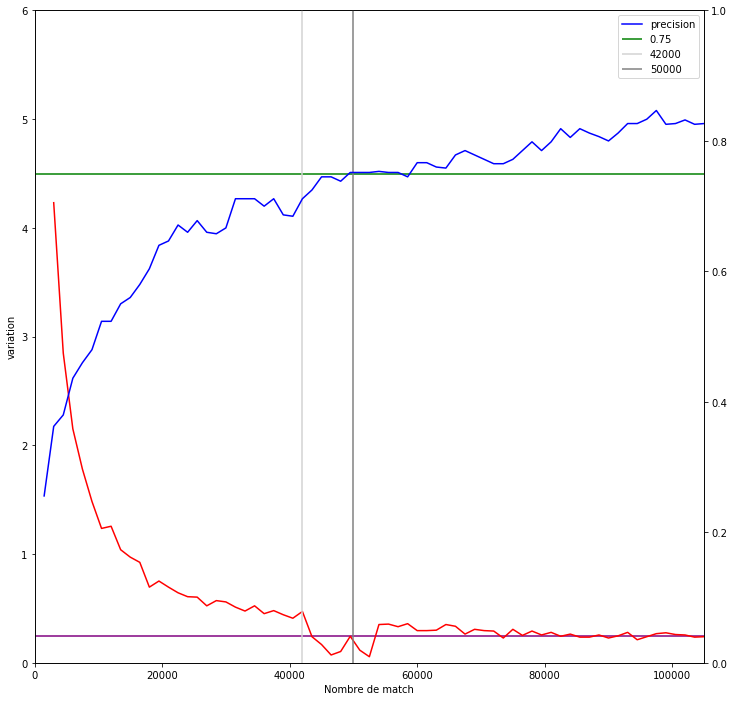

In [1299]:
nb_match=range(1500,105001,1500)

plt.plot(nb_match, [None]+var, 'red',label = 'variation')  
plt.axis([0,105000, 0, 6])
plt.xlabel('Nombre de match')
plt.ylabel('variation')
plt.hlines(y=0.25,xmin=0,xmax=105000,color='purple',label='0.25')

plt2 = plt.twinx()
plt2.axis([0,105000, 0, 1])
plt2.plot(nb_match, prec, color='blue',label='precision')
plt2.hlines(y=0.75,xmin=0,xmax=105000,color='green',label='0.75')
plt2.vlines(x=42000,ymin=0,ymax=1,color='lightgrey',label='42000')
plt2.vlines(x=50000,ymin=0,ymax=1,color='grey',label='50000')


plt2.legend(loc='upper right')
plt.show()

In [1362]:
N = 1500
liste = range(0,N)
score = score = [Glicko.create_rating()]*N
mat=matrice_diff(score)
table_ponderation = pd.DataFrame({'weight' : [0.01]*N})
random_match_glicko(28500,score,0.1,mat)
random_match_glicko_pond(13500,score,0.1,mat,15)
non_random_glicko(12000,score,0.1,mat)
score_mu= [x.mu for x in score]

100% (28500 of 28500) |##################| Elapsed Time: 0:00:56 Time:  0:00:56
100% (13500 of 13500) |##################| Elapsed Time: 0:03:09 Time:  0:03:09
100% (12000 of 12000) |##################| Elapsed Time: 0:00:44 Time:  0:00:44


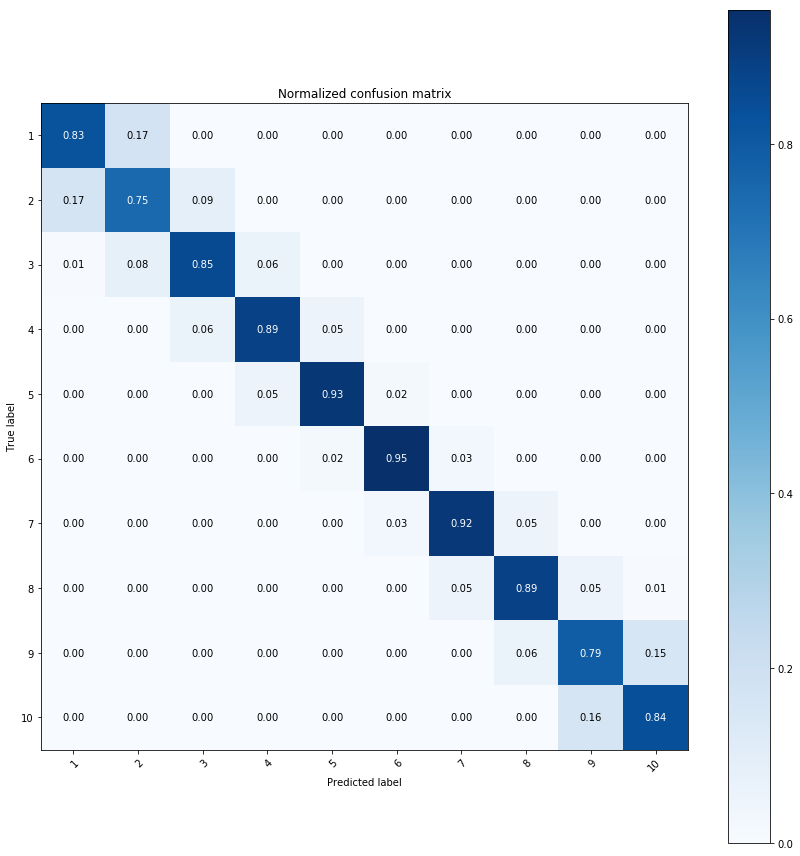

In [1363]:
df = pd.DataFrame(score_mu)
df['quality']=[quality(x,10,score_mu) for x in df[0]]
y_pred = np.array(df['quality'])
y_true = [quality(x,10,liste) for x in liste]
np.set_printoptions(precision=2)
class_names=['1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(y_true, y_pred, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [1360]:
42000-28500


13500